In [36]:
# read data: 30 ICs 
import nipype.interfaces.io as nio
import os
PD_ICA_file='/templateflow/PD_ICAs';
ICs_list=list(range(30))
ICs_list=["{:0>4d}".format(x) for x in ICs_list]
# file import
ds_ic = nio.DataGrabber(infields=['IC_id'])
ds_ic.inputs.base_directory = PD_ICA_file # database
ds_ic.inputs.template = 'melodic_IC_%4s.nii.gz' # from cwd
ds_ic.inputs.sort_filelist = True
ds_ic.inputs.IC_id = ICs_list
res_ic = ds_ic.run()
ic_list=res_ic.outputs.outfiles
# read data: 3 study groups by sub_list 
GROUPS=['PD','ET','NC']
OUT_DIR='/output/PD_ICA/'
xIC_DIR=OUT_DIR+'IC_Ximg/'
SUB_LIST=[]; AGE_LIST=[]; JCOB_LIST=[]; XJCOB_LIST=[];
N_ic=len(ic_list);
ic_names=[str(x) for x in list(range(30))]

for group_name in GROUPS:
    current_group=group_name
    current_sub_list_file = '/codes/devel/PD_Marker/'+current_group+'_info_ICA.list'
    # create dir for output
    current_OUT_DIR=OUT_DIR+current_group+'/'
    if not os.path.exists(current_OUT_DIR):
        os.makedirs(current_OUT_DIR)
    #read sub list
    with open(current_sub_list_file, 'r') as f_sub:
        sub_list_raw= f_sub.readlines()
    sub_list = [x[0:-1].split('\t')[0] for x in sub_list_raw] # remove 
    age_list = [int(x[0:-1].split('\t')[1]) for x in sub_list_raw]
    SUB_LIST.append(sub_list);  AGE_LIST.append(age_list);
    N_sub=len(sub_list)
    print(group_name, ': ', N_sub)
    # grab group Jacobians
    ds_jacobian = nio.DataGrabber(infields=['sub_id'])
    ds_jacobian.inputs.base_directory = current_OUT_DIR # database
    ds_jacobian.inputs.template = '%s_desc-preproc_T1w_space-MNI2009c_Warp_Jacobian.nii.gz' # from cwd
    ds_jacobian.inputs.sort_filelist = True
    ds_jacobian.inputs.sub_id = sub_list
    res_jacobian = ds_jacobian.run()
    jacobian_list=res_jacobian.outputs.outfiles
    JCOB_LIST.append(jacobian_list)
    # grab group Jacobian X ics
    TMP_XJCOB_LIST=[]
    for i_sub in range(N_sub):
        sub_str = sub_list[i_sub]
        sub_xic_list=[]
        for i_ic in range(N_ic):
            xic_PATH=xIC_DIR+sub_str+'-xIC'+ic_names[i_ic]+'.nii.gz'
            sub_xic_list.append(xic_PATH)
        TMP_XJCOB_LIST.append(sub_xic_list)
    XJCOB_LIST.append(TMP_XJCOB_LIST)
    
pd_sub_list = SUB_LIST[0]; et_sub_list = SUB_LIST[1]; nc_sub_list = SUB_LIST[2]; 
pd_age_list = AGE_LIST[0]; et_age_list = AGE_LIST[1]; nc_age_list = AGE_LIST[2];
pd_jaco_list=JCOB_LIST[0]; et_jaco_list=JCOB_LIST[1]; nc_jaco_list=JCOB_LIST[2];
pd_xjaco_list=XJCOB_LIST[0]; et_xjaco_list=XJCOB_LIST[1]; nc_xjaco_list=XJCOB_LIST[2];

PD :  40
ET :  29
NC :  33


In [2]:
# import necessary modules:
import numpy as np
import pandas as pd
import patsy
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as sm_stats
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style("white")



Bad key "text.kerning_factor" on line 4 in
/usr/local/miniconda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Index(['ic0', 'ic1', 'ic2', 'ic3', 'ic4', 'ic5', 'ic6', 'ic7', 'ic8', 'ic9',
       'ic10', 'ic11', 'ic12', 'ic13', 'ic14', 'ic15', 'ic16', 'ic17', 'ic18',
       'ic19', 'ic20', 'ic21', 'ic22', 'ic23', 'ic24', 'ic25', 'ic26', 'ic27',
       'ic28', 'ic29', 'age', 'LABEL'],
      dtype='object')


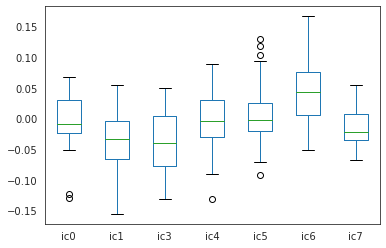

In [6]:
# IC*PD/NC mean
IC_INDEX = ['ic'+str(x) for x in range(30)]
PD_mean = pd.read_csv('mean_all_pd.csv', sep=',', header=0, index_col=0)
PD_mean.index= IC_INDEX
PD_mean.columns = pd_sub_list
PD_mean=PD_mean.T
PD_mean['age']=pd_age_list
NC_mean = pd.read_csv('mean_all_nc.csv', sep=',', header=0, index_col=0, usecols=list(range(21))+list(range(22,35,1)))
NC_mean.index= IC_INDEX
NC_mean.columns = nc_sub_list
NC_mean=NC_mean.T
NC_mean['age']=nc_age_list
#print(NC_mean.columns)
Labels = [1]*len(pd_sub_list)+[0]*len(nc_sub_list)
data_all = PD_mean.append(NC_mean)
data_all['LABEL']=Labels
print(data_all.columns)
#PD_mean.boxplot(column=['ic0', 'ic1', 'ic3', 'ic4', 'ic5', 'ic6', 'ic7'], grid=False)
NC_mean.boxplot(column=['ic0', 'ic1', 'ic3', 'ic4', 'ic5', 'ic6', 'ic7'], grid=False)
#sns.boxplot(x="Genotype", y="value", hue="years", data=data_all, palette="Set3") 

In [40]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

fit_lm = smf.glm('LABEL ~ ic0 + ic1 + ic2 + ic3 + ic4 + ic5 + ic6 + ic7 + ic8 + ic9 + ic10 + ic11 + ic12 + ic13 + ic14 + ic15 + ic16 + ic17 + ic18 + ic19 + ic20 + ic21 + ic22  + ic23 + ic24 + ic25 + ic26 + ic27 + ic28 + ic29 + age', data_all, \
                 family=sm.families.Binomial(link=sm.families.links.logit)).fit()
print(fit_lm.summary())

fit_lm1 = smf.glm('LABEL ~ ic0 + ic1 + ic2 + ic3 + ic4 + ic5 + ic6 + ic7 + age', data_all, \
                 family=sm.families.Binomial(link=sm.families.links.logit)).fit()
fit_lm1.predi
print(fit_lm1.summary())
fit_lm.predict(exog=data_all)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  LABEL   No. Observations:                   73
Model:                            GLM   Df Residuals:                       41
Model Family:                Binomial   Df Model:                           31
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21.667
Date:                Fri, 18 Sep 2020   Deviance:                       43.334
Time:                        12:02:33   Pearson chi2:                     68.2
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.3144      4.742     -1.332      0.1

/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """
/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  if __name__ == '__main__':


AttributeError: 'GLMResults' object has no attribute 'predi'

In [45]:
def n
x=fit_lm.predict(exog=data_all)

Intercept    -6.314407
ic0         -76.107733
ic1         -38.929635
ic2         -64.428637
ic3          10.870359
ic4          56.018398
ic5          40.652611
ic6          30.470969
ic7           0.949538
ic8         -34.171692
ic9          88.742838
ic10         69.763064
ic11         38.102221
ic12         64.922071
ic13         32.421756
ic14        -33.663676
ic15         31.719457
ic16        -52.648120
ic17        -22.024840
ic18        -29.190861
ic19         42.154004
ic20        -10.017445
ic21         15.575214
ic22         39.332623
ic23        -15.897673
ic24         30.394926
ic25         15.848131
ic26        -18.101645
ic27         82.280366
ic28          7.003832
ic29          5.701881
age           0.057928
dtype: float64

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  LABEL   No. Observations:                   73
Model:                            GLM   Df Residuals:                       70
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47.652
Date:                Fri, 11 Sep 2020   Deviance:                       95.305
Time:                        11:36:01   Pearson chi2:                     77.0
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4322      1.352     -1.799      0.0

/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  


5.373972038621097e-109

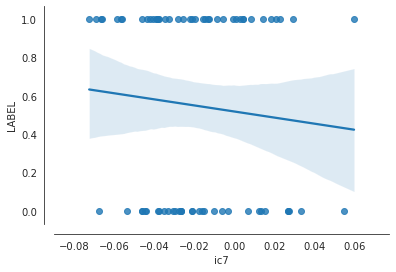

In [120]:
fit_lm2 = smf.glm('LABEL ~ ic7 + age', data_all, \
                 family=sm.families.Binomial(link=sm.families.links.logit)).fit()
print(fit_lm2.summary())
# Let's have a look at the model predictions
sns.regplot('ic7', 'LABEL', data_all)
sns.despine(offset=10);
#
def logit(x):
    return(1. / (1. + np.exp(-x)))
age = 65
linear_predictor = fit_lm2.params[0] + fit_lm2.params[-2]*age
linear_predictor
pred=logit(linear_predictor)
pred

In [ ]:
# calculate image naive corr
import nibabel as nib
import numpy as np
import time
i_PD_IC=7
PD_ICA_img=nib.load(ic_list[i_PD_IC]);
def cal_groupCorr(ic_img, img_list):
    import nibabel as nib
    from nilearn.image import resample_to_img
    from nilearn.image import math_img
    from scipy import stats
    x_list=[];
    N_sub=len(img_list)
    for i in range(N_sub):
        sub_img=nib.load(img_list[i])
        sub_img_re= resample_to_img(sub_img, ic_img)
        ic_data = ic_img.get_fdata().reshape(-1);
        nz_pos=np.flatnonzero(ic_data)
        ic_val=list(ic_data.ravel()[nz_pos])
        sub_dat = sub_img_re.get_fdata().reshape(-1);
        sub_val=list(stats.zscore(sub_dat.ravel()[nz_pos]))
        x_list.append(np.corrcoef(sub_val, ic_val)[0,1])
    return x_list
t0=time.time()
pd_jaco_corr_list=[cal_groupCorr(nib.load(x), pd_jaco_list) for x in ic_list]; 
et_jaco_corr_list=[cal_groupCorr(nib.load(x), et_jaco_list) for x in ic_list]; 
nc_jaco_corr_list=[cal_groupCorr(nib.load(x), nc_jaco_list) for x in ic_list]; 
print("naive corr of 3 groups take: ", str(time.time()-t0))

In [ ]:
#vis for naive corr
import numpy as np
def plot_corrICA(a, b, c):
    al=np.zeros(len(a)); bl=np.zeros(len(b)); cl=np.zeros(len(c));
    x=list(range(al+bl+cl))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title('Group element-wise correlation', color='C0')
    ax.plot(x[0:al-1], a,  label='PD: '+str(round(np.mean(a),4))+'~'+str(round(np.std(a),4)))
    ax.plot(x[al:al+bl-1],b ,  label='NC: '+str(round(np.mean(b),4))+'~'+str(round(np.std(b),4)))
    ax.plot(x[al+bl:al+bl+cl-1], c,  label='ET: '+str(round(np.mean(c),4))+'~'+str(round(np.std(c),4)))
    ax.legend()
plot_corrICA(pd_jaco_corr_list[], nc_jaco_corr_list[], et_jaco_corr_list[])

In [3]:
import statsmodels
import nistats

ModuleNotFoundError: No module named 'nistats'

In [ ]:
from scipy import stats
print('T-test for PD vs NC', stats.ttest_ind(rvs1,rvs2))
print('T-test for PD vs NC', stats.ttest_ind(rvs1,rvs2))

In [ ]:
grou_names=['PD']*len(pd_jaco_x_list_mean)+['ET']*len(et_jaco_x_list_mean)+['NC']*len(nc_jaco_x_list_mean);
age=pd_age_list+et_age_list+nc_age_list;
group_ica_mean=pd_jaco_x_list_mean+et_jaco_x_list_mean+nc_jaco_x_list_mean;
import pandas as pd
df_1=pd.DataFrame({'group':grou_names, 'age':age, 'ica_mean': group_ica_mean})
# generate a boxplot to see the data distribution by genotypes and years. Using boxplot, we can easily detect the 
# differences between different groups
#sns.boxplot(x="group", y="age", hue="ica_mean", data=df_1, palette="Set3") 
#df_1.to_csv('data.csv')
print(df_1)

In [19]:
import pandas as pd
df_1=pd.read_csv('data.csv')
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Ordinary Least Squares (OLS) model
# C(Genotype):C(years) represent interaction term
model= ols('ica_mean ~ (group) + (age) + (group):(age)', data=df_1).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
model1= ols('ica_mean ~ (group) + (age)', data=df_1).fit()
anova_table1 = sm.stats.anova_lm(model1, typ=3)

<KeysViewHDF5 ['HDFVersion', 'ITKVersion', 'OSName', 'OSVersion', 'TransformGroup']>
<KeysViewHDF5 ['TransformType']>


In [ ]:
print(anova_table)
print(model.conf_int())
print(anova_table1)
print(model1.conf_int())

print(model.aic, model.bic)
print(model1.aic, model1.bic)
